Count the kids G1 had

# Libraries

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from collections import Counter
import ipywidgets as widgets
from IPython.display import display

# Options

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to the directory containing your CSV
#%cd /content/drive/MyDrive/DATA/Real_Estate_Data
%cd /content/drive/MyDrive/DATA/PSID_data

Mounted at /content/drive
/content/drive/MyDrive/DATA/PSID_data


In [7]:
## Step 1.1: Load FIMS Data for Parent-Child-Grandchild Relationships
# fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/fims_tree_nodes.csv")

fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")

/tmp/ipython-input-4237000732.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fims = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")


In [8]:
# education = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J347507.csv")
psid_raw = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J355167.csv")


In [9]:
# J355167_labels.txt
J355167_labels = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/J355167_labels.txt")

# Data wrangling

In [10]:
# Create the unique cross-wave person_id column by multiplying ER30001 by 1000 and adding ER30002.
psid_raw.insert(0, 'person_id', psid_raw['ER30001'] * 1000 + psid_raw['ER30002'])

In [11]:
# A. Handle missing Gen2 IDs: fill NaN with 0 and convert to int for ID creation
fims['G2ID68'] = fims['G2ID68'].fillna(0).astype(int)
fims['G2PN'] = fims['G2PN'].fillna(0).astype(int)

In [12]:
# B. Create Gen1 (Parent) Key
fims.insert(0, 'parent_id', (fims['G1ID68'] * 1000) + fims['G1PN'])

In [13]:
# C. Create Gen2 (Child) Key
fims.insert(1, 'child_id', (fims['G2ID68'] * 1000) + fims['G2PN'])

In [14]:
# D. Select linking columns and drop duplicates
g1_map = fims[['parent_id', 'child_id', 'G1TYPE', 'G2TYPE']].drop_duplicates().copy()

In [15]:
# STEP 3A: MERGE 1 - Link the Parent's data to the Child's ID
# Matches psid_raw (person_id) to FIMS (parent_id) to attach the child_id
parent_linked_data = pd.merge(
    psid_raw,
    g1_map[['parent_id', 'child_id']],
    left_on='person_id',
    right_on='parent_id',
    how='left',
    indicator='__merge1'
)

In [16]:
# Keep only successful links (where the person is a Gen1 parent) and clean up temp columns
parent_linked_data = parent_linked_data[parent_linked_data['__merge1'] == 'both'].drop(columns=['__merge1', 'parent_id'])

In [17]:
# STEP 3B: MERGE 2 - Link the Child's data (using the child_id)
# 1. Prepare a lookup table from psid_raw for the child's characteristics
child_lookup = psid_raw[['person_id', 'ER30003', 'ER32006', 'V103']].copy()
# Rename columns to avoid confusion with parent's data
child_lookup.columns = ['child_id', 'child_rel_to_head', 'child_sample_status', 'child_V103']

In [18]:
# 2. Merge the child lookup table using the 'child_id' created in Merge 1
final_merged_data = pd.merge(
    parent_linked_data,
    child_lookup,
    left_on='child_id',
    right_on='child_id',
    how='left',
)

In [19]:
# 3. Final Renaming for Clarity
final_merged_data.rename(
    columns={
        'ER30003': 'parent_rel_to_head',
        'ER32006': 'parent_sample_status',
        'V103': 'parent_V103'
    }, inplace=True
)

In [20]:
final_merged_data.head(3)

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
0,1001,1,1,1,1,1,3.0,1.0,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
1,1002,1,1,2,2,1,3.0,1.0,2,3.0,1.0,1597,2,2,3.0,1.0,1331,1,1,3.0,1.0,108,1,1,3.0,1.0,45,1,1,3.0,1.0,81,1,1,3.0,1.0,378,1,1,3.0,1.0,3817,1,1,3.0,1.0,833,1,1,3.0,1.0,288,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
2,1003,1,1,3,1,1,3.0,1.0,7,3.0,1.0,1964,1,1,3.0,1.0,837,1,1,3.0,1.0,109,1,1,3.0,1.0,494,1,1,3.0,1.0,17,1,1,3.0,1.0,377,1,1,3.0,1.0,2848,1,1,3.0,1.0,2425,1,1,3.0,1.0,2012,1,1,3.0,1.0,2476,1,1,3.0,1.0,3273,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN


In [21]:
########
#########
#--- 1. Define Label Dictionaries based on PSID Documentation ---

# A. Relationship to Head (ER30003) - Key codes for Head, Spouse, Child
rel_labels = {
    10: 'Reference Person/Head',
    20: 'Spouse/Partner',
    30: 'Child',
    31: 'Step/Adopted Child',
    70: 'Grandchild',
    99: 'Missing/Not in FU'
}

# B. Sample Status (ER32006) - Key codes for follow-up status
sample_labels = {
    1: 'Original Sample Member',
    2: 'Sample Splitoff',
    3: 'Added Non-Sample Member',
    5: 'Temporary Loss/Re-Entry',
    0: 'Non-Sample (Died/Moved Out)'
}

# 1. DEFINE the Correct Labeling Dictionary (Using Integer Keys)
# Based on standard PSID codebook for V103 (Housing Status)
housing_labels = {
    1: 'Owns or is Buying', # Use integer 1
    2: 'Rents',             # Use integer 2
    9: 'NA/Missing'         # Include any relevant missing codes
}

# 2. APPLY the Correct Labels to the Parent's Column
# Assuming 'final_merged_data' contains the raw integer values in 'parent_V103'
final_merged_data['parent_V103'] = final_merged_data['parent_V103'].map(housing_labels)

# 3. FILTER for unique G1 Families (Re-create the final DataFrame for plotting)
g1_family_data_all_vars = final_merged_data.drop_duplicates(subset=['ER30001'], keep='first').copy()

In [22]:
num_unique_g1_entries = fims['parent_id'].nunique()
print(f"There are {num_unique_g1_entries} different G1 entries.")

There are 46648 different G1 entries.


In [23]:
# Create G1 Family Data by dropping duplicates on the Family ID (ER30001)
# keep='first' means for any family with multiple children, we keep the data
# corresponding to the first child/parent pair encountered in the DataFrame.
g1_family_data_all_vars = final_merged_data.drop_duplicates(
    subset=['ER30001'],
    keep='first'
).copy()

In [24]:
num_unique_members_g1_family = g1_family_data_all_vars['person_id'].nunique()
print(f"There are {num_unique_members_g1_family} unique members in g1_family_data_all_vars.")

There are 8034 unique members in g1_family_data_all_vars.


In [25]:
g1_family_data_all_vars.head()

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
0,1001,1,1,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,1597,1,1,3.0,1.0,1331,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
5,2001,1,2,1,1,1,3.0,NaN,1,3.0,5.0,592,1,1,3.0,5.0,415,81,9,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
21,3001,1,3,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,593,1,1,3.0,1.0,338,1,1,3.0,1.0,23,1,1,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,0.0,NaN,NaN,NaN
23,4001,1,4,1,1,1,3.0,Owns or is Buying,1,3.0,1.0,2007,1,1,3.0,8.0,53,1,1

In [26]:
g1_family_data_all_vars.shape

(8034, 238)

In [27]:
g1_family_data_all_vars.tail()

,person_id,ER30000,ER30001,ER30002,ER32000,parent_sample_status,V1,parent_V103,parent_rel_to_head,V441,V593,ER30020,ER30021,ER30022,V1101,V1264,ER30043,ER30044,ER30045,V1801,V1967,ER30067,ER30068,ER30069,V2401,V2566,ER30091,ER30092,ER30093,V3001,V3108,ER30117,ER30118,ER30119,V3401,V3522,ER30138,ER30139,ER30140,V3801,V3939,ER30160,ER30161,ER30162,V4301,V4450,ER30188,ER30189,ER30190,V5201,V5364,ER30217,ER30218,ER30219,V5701,V5864,ER30246,ER30247,ER30248,V6301,V6479,ER30283,ER30284,ER30285,V6901,V7084,ER30313,ER30314,ER30315,V7501,V7675,ER30343,ER30344,ER30345,V8201,V8364,ER30373,ER30374,ER30375,V8801,V8974,ER30399,ER30400,ER30401,V10001,V10437,ER30429,ER30430,ER30431,V11101,V11618,ER30463,ER30464,ER30465,V12501,V13023,ER30498,ER30499,ER30500,V13701,V14126,ER30535,ER30536,ER30537,V14801,V15140,ER30570,ER30571,ER30572,V16301,V16641,ER30606,ER30607,ER30608,V17701,V18072,ER30642,ER30643,ER30644,V19001,V19372,ER30689,ER30690,ER30691,V20301,V20672,ER30733,ER30734,ER30735,V21601,V22427,ER30806,ER30807,ER30808,ER2001,ER2032,ER33101,ER33102,ER33103,ER5001,ER5031,ER33201,ER33202,ER33203,ER7001,ER7031,ER33301,ER33302,ER33303,ER10001,ER10035,ER33401,ER33402,ER33403,ER13001,ER13040,ER33501,ER33502,ER33503,ER17001,ER17043,ER33601,ER33602,ER33603,ER21001,ER21042,ER33701,ER33702,ER33703,ER25001,ER25028,ER33801,ER33802,ER33803,ER36001,ER36028,ER33901,ER33902,ER33903,ER42001,ER42029,ER34001,ER34002,ER34003,ER47301,ER47329,ER34101,ER34102,ER34103,ER53001,ER53029,ER34201,ER34202,ER34203,ER60001,ER60030,ER64841,ER34301,ER34302,ER34303,ER34331,ER34335,ER66001,ER66030,ER70913,ER34501,ER34502,ER34503,ER34530,ER34534,ER72001,ER72030,ER76930,ER34701,ER34702,ER34703,ER34730,ER34734,ER78001,ER78031,ER81177,ER34901,ER34902,ER34903,ER34930,ER34934,ER82001,ER82032,ER85154,ER35101,ER35102,ER35103,ER35130,ER35134,child_id,child_rel_to_head,child_sample_status,child_V103
90834,9304001,1,9304,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,1.0,9516,1,10,4.0,1.0,4838,1,10,6.0,1.0,3842,1,10,6.0,1.0,5082,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9304003.0,0.0,1.0,NaN
90838,9305001,1,9305,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,5.0,9045,1,10,4.0,5.0,9041,1,10,6.0,5.0,3843,1,10,6.0,5.0,3391,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9305003.0,0.0,1.0,NaN
90846,9306001,1,9306,1,1,1,NaN,NaN,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,4.0,1.0,9046,1,10,4.0,1.0,9678,1,10,6.0,1.0,3844,1,10,6.0,1.0,6599,1,10,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,NaN,NaN,NaN,0,0,0,0,0,9306003.0,0.0,1.0,NaN
90856,9307001,1,9307,1,

In [28]:
nan_count = g1_family_data_all_vars['parent_V103'].isna().sum()
print(f"Number of NaN values in 'parent_V103': {nan_count}")

Number of NaN values in 'parent_V103': 5688


XXXXXXXXX

/tmp/ipython-input-3958750753.py:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fims_data = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")


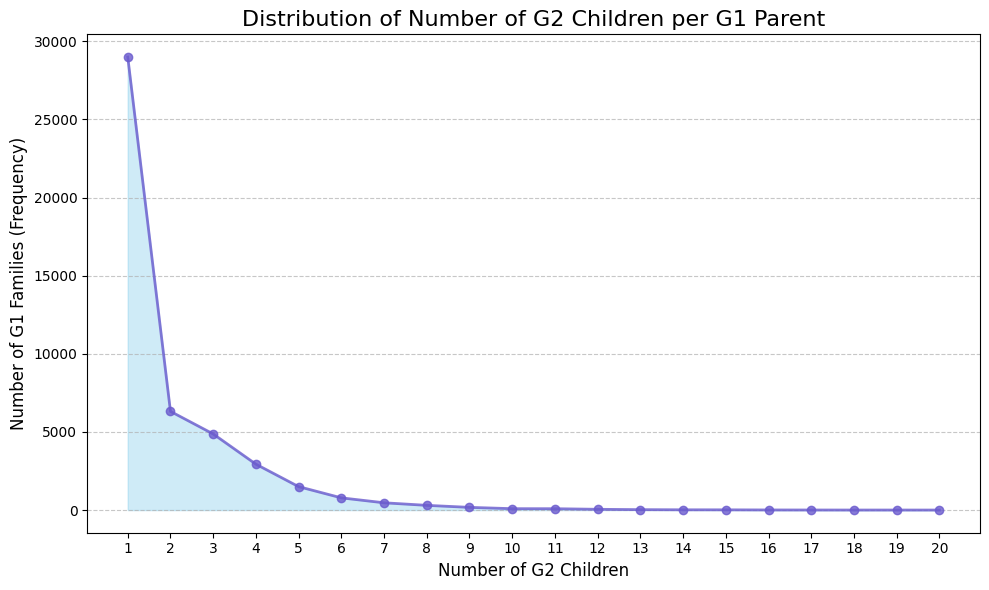

In [29]:

# Assuming FIMS_Beth.csv is accessible (e.g., via the drive mount in your notebook)
# If FIMS_Beth.csv is already loaded, replace pd.read_csv with your existing DataFrame name

# 1. Load FIMS Data (If not already loaded)
# try:
#     fims_data = pd.read_csv("FIMS_Beth.csv")
# except FileNotFoundError:
#     print("Error: FIMS_Beth.csv not found. Please verify the file path.")
#     # If loading fails, you'll need to use your specific path from the mounted drive.
#     raise

fims_data = pd.read_csv("/content/drive/MyDrive/DATA/PSID_data/FIMS_Beth.csv")

# 2. Prepare Unique IDs
# Impute missing G2 IDs (if any) with 0 and convert to integer
fims_data['G2ID68'] = fims_data['G2ID68'].fillna(0).astype(int)
fims_data['G2PN'] = fims_data['G2PN'].fillna(0).astype(int)

# Create the unique Gen1 (parent) and Gen2 (child) IDs
fims_data['parent_id'] = (fims_data['G1ID68'] * 1000) + fims_data['G1PN']
fims_data['child_id'] = (fims_data['G2ID68'] * 1000) + fims_data['G2PN']

# 3. Count the Number of Children (G2) per Parent (G1)
# Group by the unique parent ID and count the number of DISTINCT children
g1_map_unique = fims_data.drop_duplicates(subset=['parent_id', 'child_id']).copy()

# This is the core calculation: count unique children per unique parent
child_count_by_parent = g1_map_unique.groupby('parent_id')['child_id'].nunique().reset_index()
child_count_by_parent.columns = ['parent_id', 'Number_of_Children']

# 4. Prepare data for Plotting (Frequency Distribution)
# Count how many parents had 1 child, 2 children, 3 children, etc.
plot_data = child_count_by_parent['Number_of_Children'].value_counts().reset_index()
plot_data.columns = ['Number_of_Children', 'Frequency']
plot_data = plot_data.sort_values('Number_of_Children', ascending=True)


# 5. Create the Area Plot (Filled Line Plot)
plt.figure(figsize=(10, 6))

# Use fill_between for the "area under curve" effect
plt.fill_between(
    plot_data['Number_of_Children'],
    plot_data['Frequency'],
    color="skyblue",
    alpha=0.4
)
# Plot the line on top
plt.plot(
    plot_data['Number_of_Children'],
    plot_data['Frequency'],
    color="Slateblue",
    alpha=0.8,
    linewidth=2,
    marker='o'
)

plt.title('Distribution of Number of G2 Children per G1 Parent', fontsize=16)
plt.xlabel('Number of G2 Children', fontsize=12)
plt.ylabel('Number of G1 Families (Frequency)', fontsize=12)

# Ensure x-axis ticks are set to the integer number of children observed
plt.xticks(plot_data['Number_of_Children'].unique())
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()